In [ ]:
#%pip install https://github.com/chovanecm/python-genetic-algorithm/archive/master.zip#egg=mchgenalg
#%pip install torch

In [1]:
import torch
import gym 
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
torch.cuda.is_available()

c:\Python310\lib\site-packages\gym\wrappers\monitoring\video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


False

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)

c:\Python310\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


Model parameters, I use a Genetic Algorithm to find the best parameters for the model.

In [3]:
# hyperparameters
hyperparams = {
    'batch_size': 250,
    'beta': 0.2,
    'lambda': 0.1,
    'eta': 1.0,
    'gamma': 0.2,
    'max_episode_length': 200,
    'min_progress': 15,
    'action_repeats': 6,
    'frames_per_state': 4,
    'learning_rate': 0.001,
    'skip_frames': 4
}

In [4]:
def preprocess_frame(frame, new_size=(42,42), to_gray=True):
    if to_gray:
        return resize(frame, new_size, anti_aliasing=True).max(axis=2)
    else:
        return resize(frame, new_size, anti_aliasing=True)

In [5]:
from collections import deque
from torch import nn
from torch import optim
import torch.nn.functional as F

def prepare_state(state):
    return torch.from_numpy(preprocess_frame(state, to_gray=True)).float().unsqueeze(0)

def prepare_multi_states(state1, state2):
    state1 = state1.clone()
    temp = torch.from_numpy(preprocess_frame(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = temp
    return state1

def prepare_initial_state(state, N=4):
    state_ = torch.from_numpy(preprocess_frame(state, to_gray=True)).float()
    tmp = state_.repeat((N, 1, 1))
    return tmp.unsqueeze(0)

In [6]:
# Policy definition

def policy(qvalues, eps=None):
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0, high=qvalues.shape[1], size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)

In [7]:
# Experience replay memory in order to sample mini batches of experiences for training
from random import shuffle

class ExperienceReplayMemory:
    def __init__(self, N=500, batch_size=100):
        self.N = N
        self.batch_size = batch_size
        self.memory = []
        self.counter = 0

    def add_memory(self, state1, action, reward, state2):
        self.counter += 1
        if self.counter % self.N == 0:
            self.shuffle_memory()
        if(len(self.memory) < self.N):
            self.memory.append((state1, action, reward, state2))
        else:
            rand_idx = np.random.randint(0, self.N - 1)
            self.memory[rand_idx] = (state1, action, reward, state2)

    def shuffle_memory(self):
        shuffle(self.memory)

    def get_batch(self):
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: Memory is empty")
            return None
        
        ind = np.random.choice(np.arange(len(self.memory)), batch_size, replace=False)
        batch = [self.memory[i] for i in ind]
        state1_batch = torch.stack([x[0].squeeze(0) for x in batch], dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(0) for x in batch], dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch


In [8]:
# Intrinsic curiosity module: 3 diverse nn networks (forward, inverse, encoder)

class Phi(nn.Module): # Encoder
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
    
    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=1)
        return y
    
class Gnet(nn.Module): # Inverse model
    def __init__(self):
        super(Gnet, self).__init__()
        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, env.action_space.n)

    def forward(self, state1, state2):
        x = torch.cat((state1, state2), dim=1)
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        y = F.softmax(y, dim=1)
        return y
    
class Fnet(nn.Module): # Forward model
    def __init__(self):
        super(Fnet, self).__init__()
        self.fc1 = nn.Linear(300, 256)
        self.fc2 = nn.Linear(256, 288)

    def forward(self, state, action):
        action_ = torch.zeros((action.shape[0], env.action_space.n))
        indices = torch.stack((torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1
        x = torch.cat((state, action_), dim=1)
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return y

In [9]:
# Q network

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.fc1 = nn.Linear(288, 100)
        self.fc2 = nn.Linear(100, env.action_space.n)

    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.fc1(y))
        y = self.fc2(y)
        return y

In [10]:
replay = ExperienceReplayMemory(N=1500, batch_size=hyperparams['batch_size'])
qnet = Qnet()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(qnet.parameters()) + list(encoder.parameters()) + list(forward_model.parameters()) + list(inverse_model.parameters())
optimizer = optim.Adam(all_model_params, lr=hyperparams['learning_rate'])

In [11]:
def loss_fn(q_loss, forward_loss, inverse_loss, beta, lambda_value):
    loss_ = (1 - beta)*inverse_loss
    loss_ += hyperparams['beta']*forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss_ += lambda_value*q_loss
    return loss_

def reset_env():
    env.reset()
    state1 = prepare_initial_state(env.render(mode='rgb_array'))
    return state1

In [12]:
def ICM(state1, action, state2, forward_scale = 1., inverse_scale = 1e4):
    state1_hat = encoder(state1)
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach())
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat)
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

def minibatch_train(use_explicit=True, gamma = hyperparams['gamma']):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()
    action_batch = action_batch.view(action_batch.shape[0], 1)
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch)
    i_reward = (1./hyperparams['eta'])*forward_pred_err 
    reward = i_reward.detach() 
    if use_explicit:
        reward += reward_batch
    qvals = qnet(state2_batch)
    reward += gamma*torch.max(qvals)
    reward_pred = qnet(state1_batch) 
    reward_target = reward_pred.clone()
    indices = torch.stack((torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

In [13]:
def train(epochs, lambda_value=hyperparams['lambda'], beta=hyperparams['beta'], gamma=hyperparams['gamma'], eps = 0.15):
    env.reset()
    state1 = prepare_initial_state(env.render(mode='rgb_array'))
    eps = eps
    losses = []
    episode_length = 0
    switch_to_eps_greedy = 1000
    state_deque = deque(maxlen=hyperparams['frames_per_state'])
    env.reset()
    _, _, _,info_0 = env.step(0)
    env.reset()
    last_x_pos = info_0['x_pos']
    e_reward = 0
    ep_lengths = []
    #use_explicit = False
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        episode_length += 1
        q_val_pred = qnet(state1)
        if i > switch_to_eps_greedy:
            action = int(policy(q_val_pred, eps))
        else:
            action = int(policy(q_val_pred))
        for j in range(hyperparams['action_repeats']):
            for k in range(hyperparams['skip_frames']):
                state2, e_reward_, done, info = env.step(action)
                e_reward += e_reward_
                if done:
                    state1 = reset_env()
                    break 
            state_deque.append(prepare_state(state2))
        state2 = torch.stack(list(state_deque), dim=1)
        replay.add_memory(state1, action, e_reward, state2)
        e_reward = 0
        if episode_length > hyperparams['max_episode_length']:
            if (info['x_pos'] - last_x_pos) < hyperparams['min_progress']:
                done = True
            else:
                last_x_pos = info['x_pos']
        if done:
            ep_lengths.append(episode_length)
            episode_length = 0
            state1 = reset_env()
            last_x_pos = info_0['x_pos']
        else:
            state1 = state2
        if len(replay.memory) < hyperparams['batch_size']:
            continue
        forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_explicit = False, gamma=gamma)
        loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err, lambda_value=lambda_value, beta=beta)
        loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(), inverse_pred_err.flatten().mean())
        losses.append(loss_list)
        loss.backward()
        optimizer.step()
    return ep_lengths, losses


  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\UTENTE\AppData\Local\Temp\ipykernel_15156\3355323674.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)
100%|██████████| 2000/2000 [23:32<00:00,  1.42it/s]


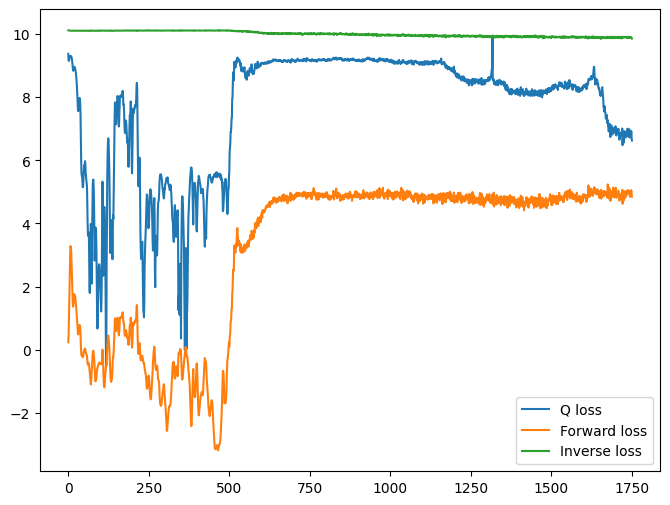

In [14]:
ep_len, losses_plot =train(epochs=2000, lambda_value=hyperparams['lambda'], beta=hyperparams['beta'], gamma=hyperparams['gamma'], eps = 0.15)
losses_q = [x[0].detach().numpy() for x in losses_plot]
losses_f = [x[1].detach().numpy() for x in losses_plot]
losses_i = [x[2].detach().numpy() for x in losses_plot]
plt.figure(figsize=(8,6))
plt.plot(np.log(losses_q), label='Q loss')
plt.plot(np.log(losses_f), label='Forward loss')
plt.plot(np.log(losses_i), label='Inverse loss')
plt.legend()
plt.show()


In [15]:
eps = 0.1
done = True
state_deque = deque(maxlen=hyperparams['frames_per_state'])
for step in range(5000):
    if done: 
        env.reset()
        state1 = prepare_initial_state(env.render(mode='rgb_array'))
    q_val_pred = qnet(state1)
    action = int(policy(q_val_pred, eps))
    state2, reward, done, info = env.step(action)
    state2 = prepare_multi_states(state1, state2)
    state1 = state2
    env.render()
env.close()

c:\Python310\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Impossibile cambiare la modalità del thread dopo averla impostata
  warnings.warn(str(err))


Genetic algorithm for parameter optimization:

In [29]:
def decode_genome(partial_genome):
    prod = 0
    count = 0
    for i in list(reversed(partial_genome)):
        if i == False:
            prod += 0
        else:
            prod += 2**abs(i-len(partial_genome)+1)
        count += 1
    return prod/1000

In [14]:
from mchgenalg import GeneticAlgorithm

times_evaluated = 0
best_epochs = -1

# function that evaluates the fitness 
def fitness_function(genome):
    global times_evaluated
    times_evaluated += 1
    print("evaluating genome for the {} time".format(times_evaluated))
    beta = decode_genome(genome[0:10])
    if beta < 0:
        beta = 0
    elif beta > 1:
        beta = 1
    lambda_ = decode_genome(genome[11:21])
    if lambda_ < 0:
        lambda_ = 0
    elif lambda_ > 1:
        lambda_ = 1
    gamma = decode_genome(genome[22:33])
    if gamma < 0:
        gamma = 0
    elif gamma > 1:
        gamma = 1
    eps = decode_genome(genome[56:66])
    if eps < 0:
        eps = 0
    elif eps > 1:
        eps = 1
    epochs_default = 100
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = JoypadSpace(env, COMPLEX_MOVEMENT)
    ep_lengths, losses = train(epochs_default, lambda_value=lambda_, beta=beta, gamma=gamma, eps=eps)
    return np.mean(ep_lengths)

pop_size = 10
genome_length = 66
ga = GeneticAlgorithm(fitness_function)
ga.generate_binary_population(pop_size, genome_length)
ga.number_of_pairs = 10
ga.mutation_rate = 0.1
ga.selective_pressure = 1.5
ga.mutation_rate = 0.1
ga.allow_random_parent = True
ga.single_point_cross_over = False
ga.run
best_genome = ga.get_best_genome()
print("Best genome: {}".format(best_genome))

evaluating genome for the 1 time


c:\Python310\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(
C:\Users\UTENTE\AppData\Local\Temp\ipykernel_1512\3355323674.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


evaluating genome for the 2 time
evaluating genome for the 3 time
evaluating genome for the 4 time
evaluating genome for the 5 time
evaluating genome for the 6 time
evaluating genome for the 7 time
evaluating genome for the 8 time
evaluating genome for the 9 time
evaluating genome for the 10 time
Best genome: (array([ True, False, False,  True,  True, False,  True,  True, False,
        True, False, False,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False, False,  True,  True,  True,
        True, False, False,  True, False, False,  True, False,  True,
       False,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False, False,  True, False,  True,  True,
       False, False,  True]), nan)


In [30]:
beta = decode_genome(best_genome[0][0:10])
print("beta: {}".format(beta))
lambda_ = decode_genome(best_genome[0][11:21])
print("lambda: {}".format(lambda_))
gamma = decode_genome(best_genome[0][22:33])
print("gamma: {}".format(gamma))
eps = decode_genome(best_genome[0][56:66])
print("eps: {}".format(eps))

beta: 1.536
lambda: 1.792
gamma: 2.048
eps: 1.024
